In [2]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [3]:
DATASET_PATH = 'data/speech_commands'
data_dir = pathlib.Path(DATASET_PATH)

In [4]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[(commands != 'README.md') & (commands != '.DS_Store')]
print('Commands:', commands)

Commands: ['down' 'go' 'left' 'off' 'on' 'right' 'stop' 'up']


In [5]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 30561 files belonging to 8 classes.
Using 24449 files for training.
Using 6112 files for validation.

label names: ['down' 'go' 'left' 'off' 'on' 'right' 'stop' 'up']


In [6]:
train_ds.element_spec

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [7]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [8]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [24]:
for example_audio, example_labels in train_ds.take(1):  
  print(example_audio.shape)
  print(example_labels.shape)

(64, 16000)
(64,)


In [25]:
label_names[[1,1,3,0]]

array(['go', 'go', 'off', 'down'], dtype='<U5')

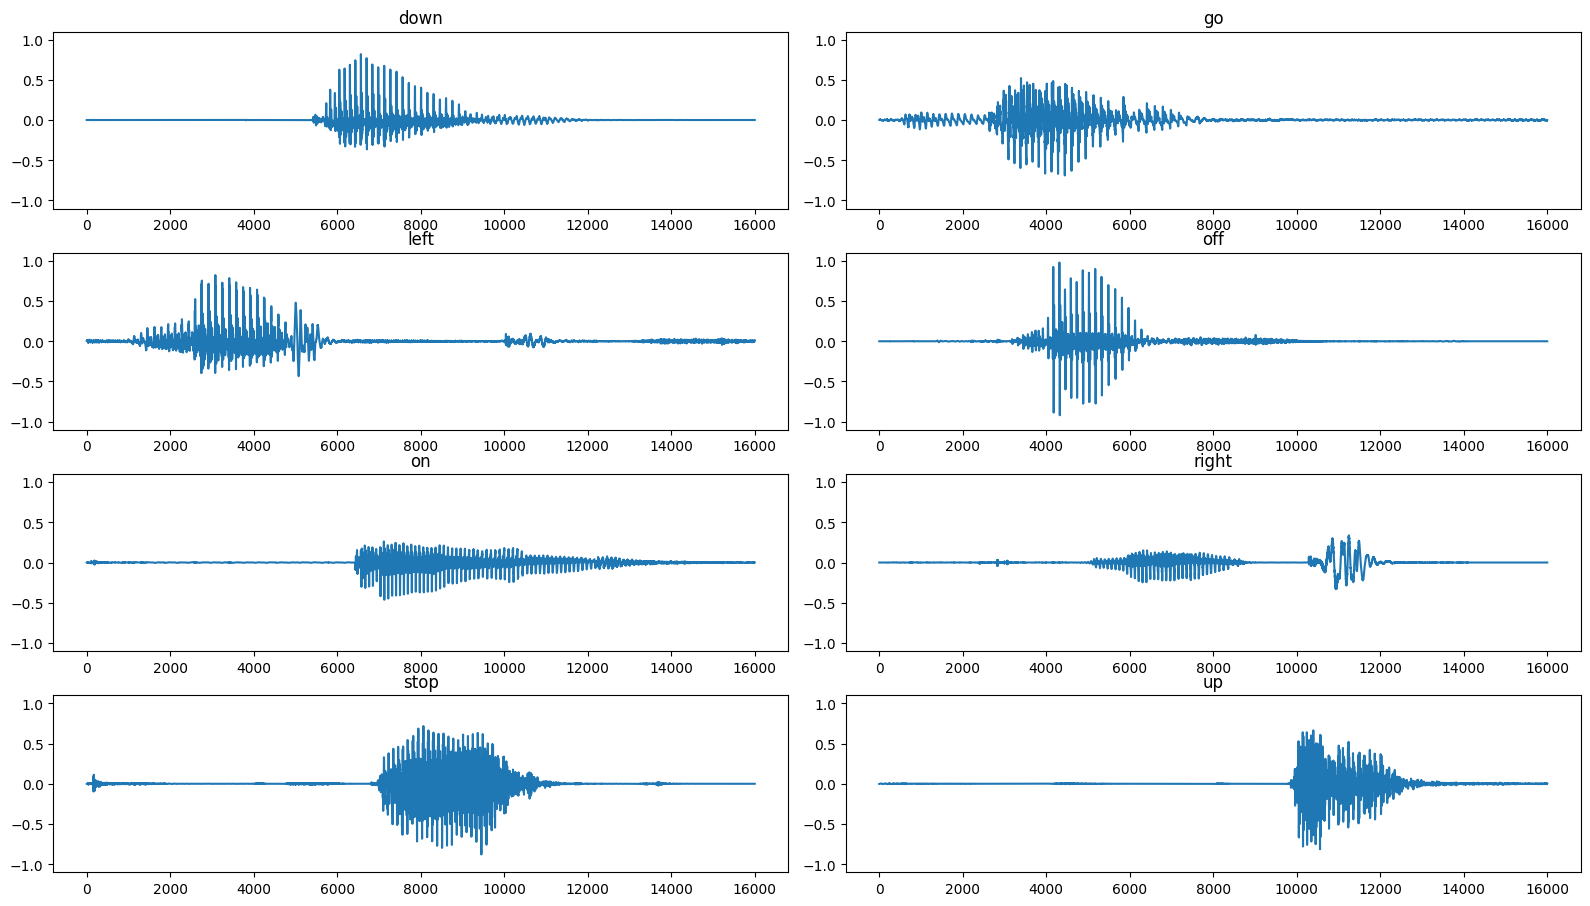

In [46]:
for example_audio, example_labels in train_ds.take(1): 
  break

rows = 4
cols = 2
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9), )
fig.tight_layout()

labels_found = []
for i in range (n):
  for label_idx, label in enumerate(example_labels):
    if (label not in labels_found) & (label == i):
      r = i // cols
      c = i % cols
      ax = axes[r][c]
      ax.plot(example_audio[label_idx].numpy())
      label_name = label_names[example_labels[label_idx]]
      ax.set_title(label_name)
      ax.set_ylim([-1.1,1.1])
      labels_found.append(label)
      break

In [27]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [28]:
for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: go
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: off
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: right
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


In [29]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

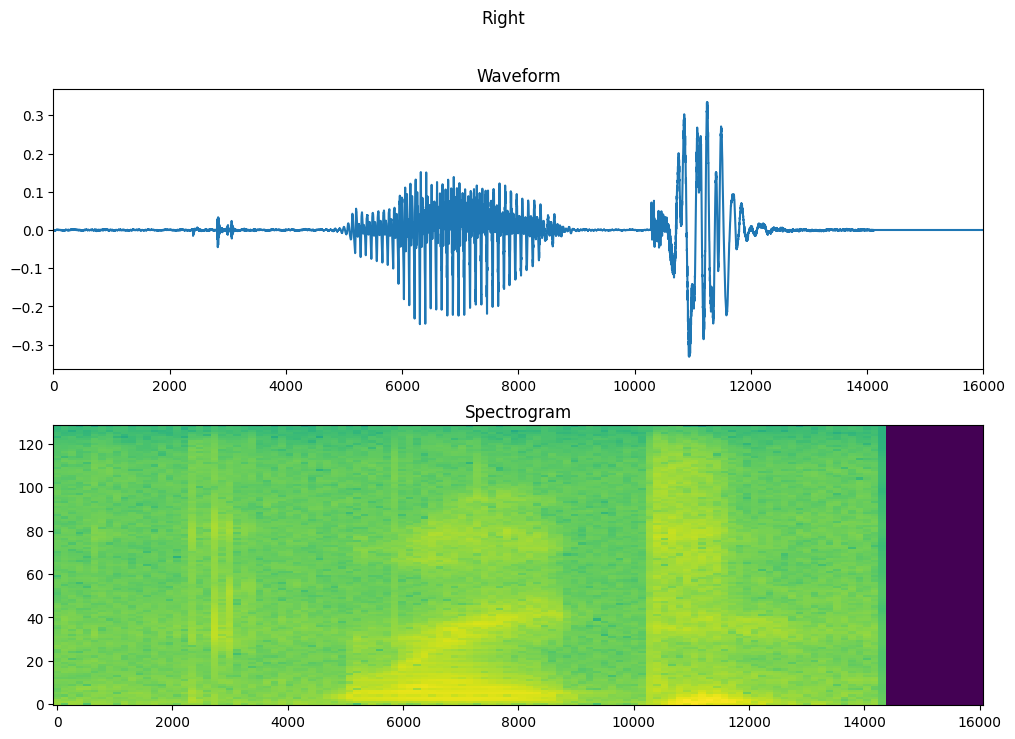

In [30]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

In [31]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [32]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [34]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

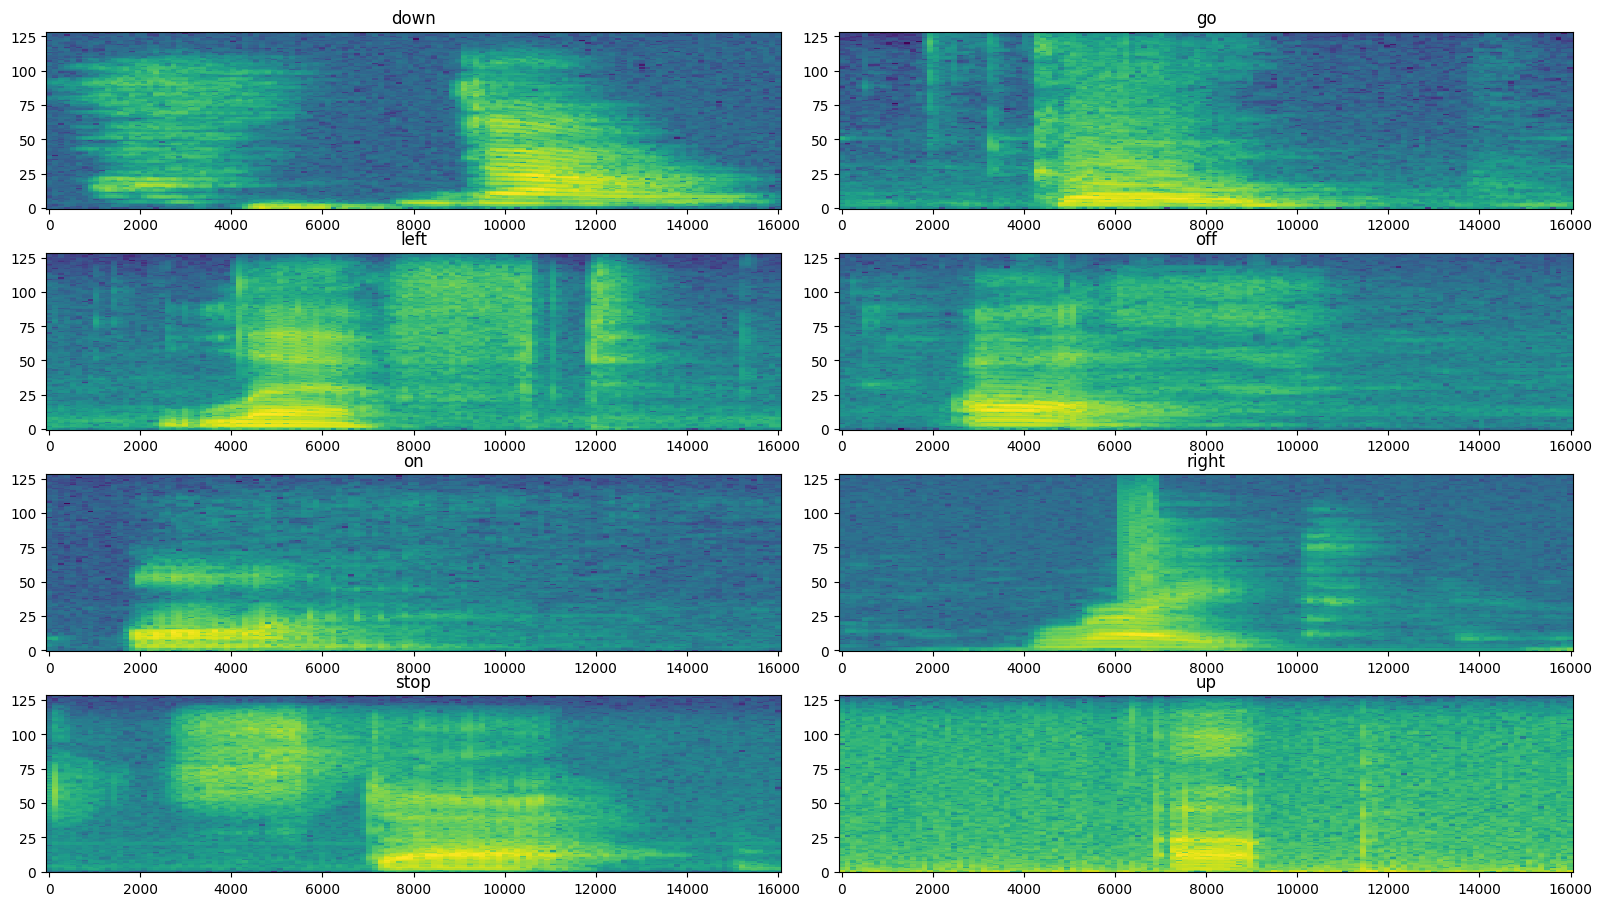

In [45]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

rows = 4
cols = 2
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))
fig.tight_layout()

labels_found = []
for i in range (n):
  for label_idx, label in enumerate(example_spect_labels):
    if (label not in labels_found) & (label == i):
      r = i // cols
      c = i % cols
      ax = axes[r][c]
      plot_spectrogram(example_spectrograms[label_idx].numpy(), ax)
      label_name = label_names[example_spect_labels[label_idx].numpy()]
      ax.set_title(label_name)
      labels_found.append(label)
      break


plt.show()


In [19]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [60]:
input_shape = example_spectrograms.shape[1:3]
print('Input shape:', input_shape)
num_labels = len(label_names)

Input shape: (124, 129)


In [20]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))


Input shape: (124, 129, 1)


In [21]:
num_labels

8

In [22]:
class ExportModel(tf.Module):
  def __init__(self, model):
    self.model = model

    # Accept either a string-filename or a batch of waveforms.
    # YOu could add additional signatures for a single wave, or a ragged-batch. 
    self.__call__.get_concrete_function(
        x=tf.TensorSpec(shape=(), dtype=tf.string))
    self.__call__.get_concrete_function(
       x=tf.TensorSpec(shape=[None, 16000], dtype=tf.float32))


  @tf.function
  def __call__(self, x):
    # If they pass a string, load the file and decode it. 
    if x.dtype == tf.string:
      x = tf.io.read_file(x)
      x, _ = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
      x = tf.squeeze(x, axis=-1)
      x = x[tf.newaxis, :]

    x = get_spectrogram(x)  
    result = self.model(x, training=False)

    class_ids = tf.argmax(result, axis=-1)
    class_names = tf.gather(label_names, class_ids)
    return {'predictions':result,
            'class_ids': class_ids,
            'class_names': class_names}

In [23]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy

## Training Model LSTM 1

In [63]:
model = tf.keras.Sequential([
    layers.LSTM(units=128, return_sequences=True, input_shape=(124, 129)),
    layers.Dropout(0.5),
    layers.LSTM(units=64),
    layers.Dense(num_labels, activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 124, 128)          132096    
                                                                 
 dropout_1 (Dropout)         (None, 124, 128)          0         
                                                                 
 lstm_5 (LSTM)               (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 8)                 520       
                                                                 
Total params: 182,024
Trainable params: 182,024
Non-trainable params: 0
_________________________________________________________________


In [25]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=SparseCategoricalCrossentropy(),
    metrics=['accuracy'],
)

In [26]:
EPOCHS = 10
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
383/383 [==============================] - 2151s 6s/step - loss: 1.6440 - accuracy: 0.3636 - val_loss: 1.5287 - val_accuracy: 0.4211
Epoch 2/10
383/383 [==============================] - 912s 2s/step - loss: 1.5990 - accuracy: 0.4120 - val_loss: 1.7188 - val_accuracy: 0.3559
Epoch 3/10
383/383 [==============================] - 881s 2s/step - loss: 1.2692 - accuracy: 0.5473 - val_loss: 0.9816 - val_accuracy: 0.6882
Epoch 4/10
383/383 [==============================] - 896s 2s/step - loss: 0.6599 - accuracy: 0.7888 - val_loss: 0.5501 - val_accuracy: 0.8188
Epoch 5/10
383/383 [==============================] - 912s 2s/step - loss: 0.4690 - accuracy: 0.8469 - val_loss: 0.4044 - val_accuracy: 0.8714
Epoch 6/10
383/383 [==============================] - 912s 2s/step - loss: 0.3492 - accuracy: 0.8840 - val_loss: 0.3019 - val_accuracy: 0.9010
Epoch 7/10
383/383 [==============================] - 907s 2s/step - loss: 0.2795 - accuracy: 0.9069 - val_loss: 0.2584 - val_accuracy: 0.912

Text(0, 0.5, 'Accuracy [%]')

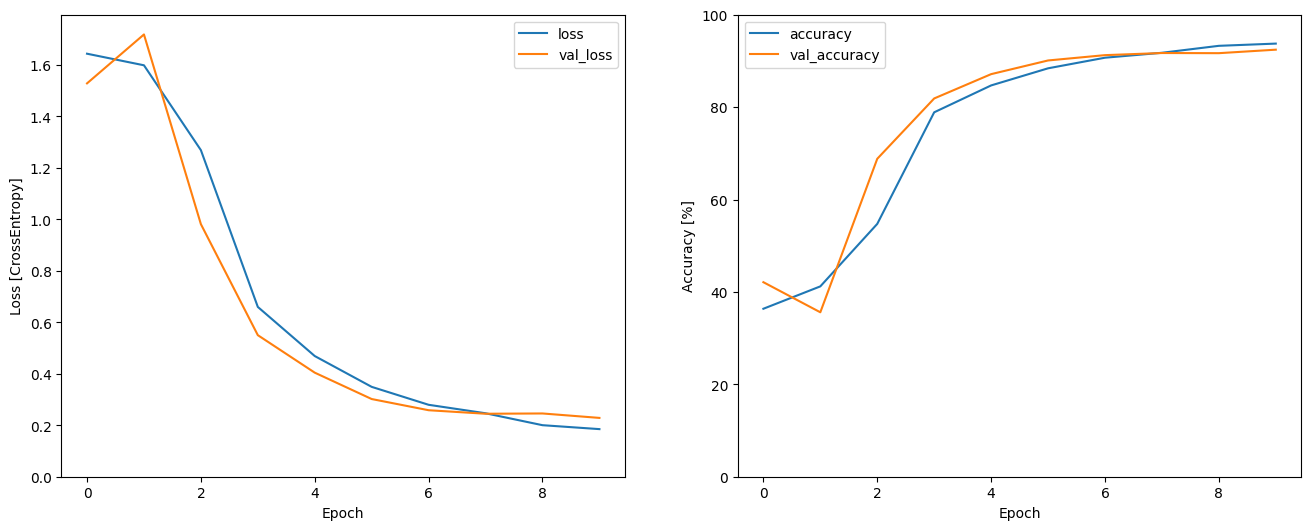

In [27]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

In [28]:
model.evaluate(test_spectrogram_ds, return_dict=True)

48/48 [==============================] - 40s 815ms/step - loss: 0.2528 - accuracy: 0.9167


{'loss': 0.25280675292015076, 'accuracy': 0.9166666865348816}

In [29]:
y_pred = model.predict(test_spectrogram_ds)
y_pred = tf.argmax(y_pred, axis=1)

48/48 [==============================] - 31s 616ms/step


In [30]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)


In [31]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_true, y_pred)

print("Accuracy Score=",accuracy)

Accuracy Score= 0.9166666666666666


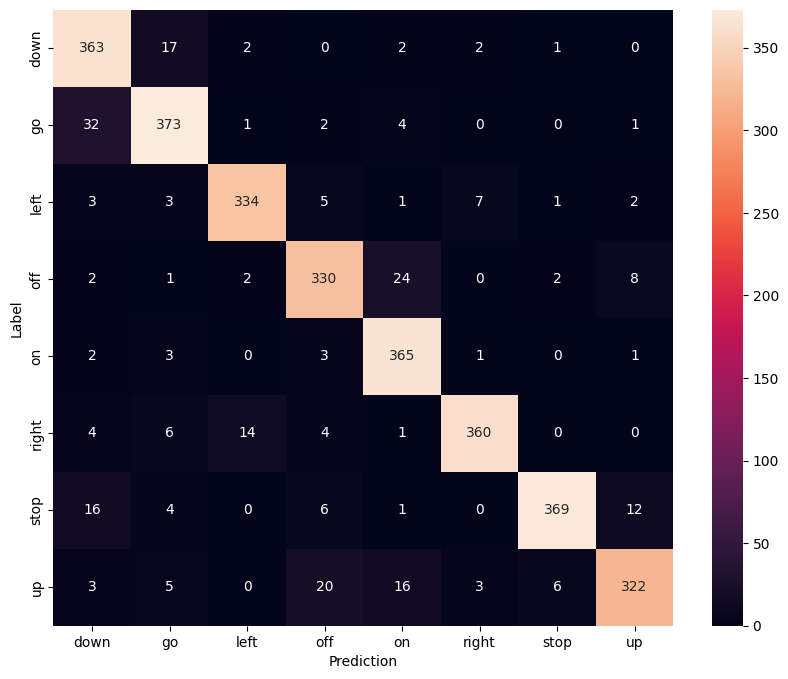

In [32]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [33]:
export = ExportModel(model)
# export(tf.constant(str(data_dir/'on/0a2b400e_nohash_0.wav')))

In [34]:
tf.saved_model.save(export, "LSTM_8words_3")

INFO:tensorflow:Assets written to: LSTM_8words_3\assets


INFO:tensorflow:Assets written to: LSTM_8words_3\assets


In [35]:
imported = tf.saved_model.load("LSTM_8words_3")
imported(waveform[tf.newaxis, :])

{'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([2], dtype=int64)>,
 'predictions': <tf.Tensor: shape=(1, 8), dtype=float32, numpy=
 array([[4.7936360e-04, 1.3344010e-04, 9.9018174e-01, 3.9796997e-04,
         4.5772544e-05, 8.0425162e-03, 2.5221688e-04, 4.6691200e-04]],
       dtype=float32)>,
 'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'left'], dtype=object)>}

## Training Model LSTM 2

In [36]:
model2 = tf.keras.Sequential([
    layers.LSTM(units=256, return_sequences=True, input_shape=(124, 129)),
    layers.Dropout(0.5),
    layers.LSTM(units=128),
    layers.Dense(num_labels, activation='softmax')
])

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 124, 256)          395264    
                                                                 
 dropout (Dropout)           (None, 124, 256)          0         
                                                                 
 lstm_3 (LSTM)               (None, 128)               197120    
                                                                 
 dense_1 (Dense)             (None, 8)                 1032      
                                                                 
Total params: 593,416
Trainable params: 593,416
Non-trainable params: 0
_________________________________________________________________


In [37]:
model2.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=SparseCategoricalCrossentropy(),
    metrics=['accuracy'],
)

In [38]:
EPOCHS = 10
history2 = model2.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
383/383 [==============================] - 833s 2s/step - loss: 1.7593 - accuracy: 0.3005 - val_loss: 1.6986 - val_accuracy: 0.3303
Epoch 2/10
383/383 [==============================] - 849s 2s/step - loss: 1.6498 - accuracy: 0.3642 - val_loss: 1.2970 - val_accuracy: 0.5382
Epoch 3/10
383/383 [==============================] - 847s 2s/step - loss: 0.8801 - accuracy: 0.7051 - val_loss: 0.5215 - val_accuracy: 0.8339
Epoch 4/10
383/383 [==============================] - 866s 2s/step - loss: 0.5934 - accuracy: 0.8084 - val_loss: 0.4068 - val_accuracy: 0.8599
Epoch 5/10
383/383 [==============================] - 858s 2s/step - loss: 0.3880 - accuracy: 0.8710 - val_loss: 0.3571 - val_accuracy: 0.8868
Epoch 6/10
383/383 [==============================] - 870s 2s/step - loss: 0.3059 - accuracy: 0.8989 - val_loss: 0.3004 - val_accuracy: 0.9000
Epoch 7/10
383/383 [==============================] - 879s 2s/step - loss: 0.2550 - accuracy: 0.9157 - val_loss: 0.2254 - val_accuracy: 0.9237

Text(0, 0.5, 'Accuracy [%]')

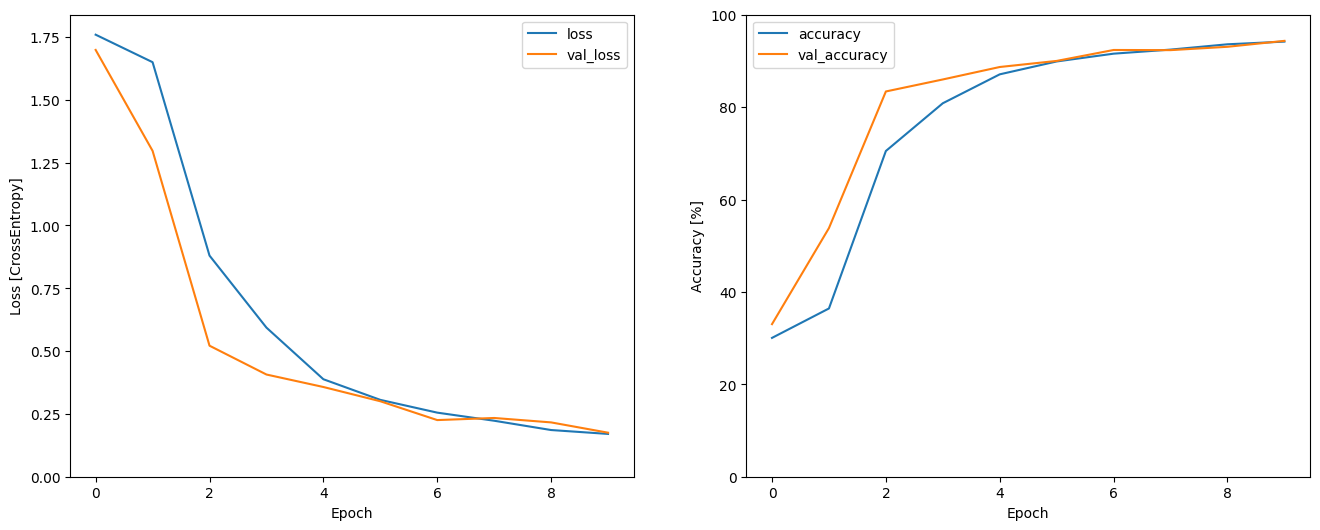

In [39]:
metrics = history2.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

In [40]:
model2.evaluate(test_spectrogram_ds, return_dict=True)

48/48 [==============================] - 31s 650ms/step - loss: 0.1883 - accuracy: 0.9398


{'loss': 0.18833261728286743, 'accuracy': 0.9397786259651184}

In [42]:
y_pred2 = model2.predict(test_spectrogram_ds)
y_pred2 = tf.argmax(y_pred2, axis=1)

48/48 [==============================] - 29s 603ms/step


In [43]:
y_true2 = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)


In [45]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_true2, y_pred2)

print("Accuracy Score=",accuracy)

Accuracy Score= 0.9397786458333334


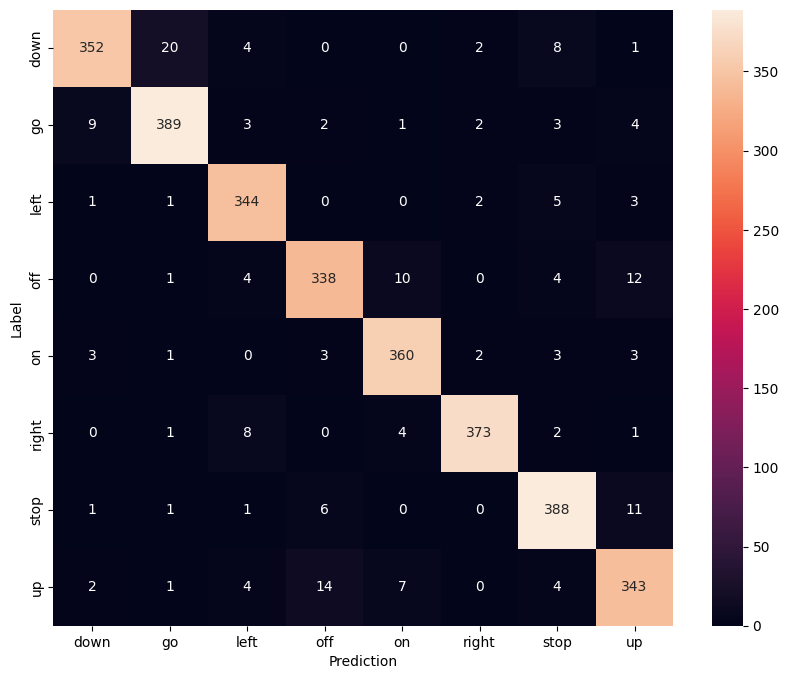

In [46]:
confusion_mtx = tf.math.confusion_matrix(y_true2, y_pred2)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [47]:
export2 = ExportModel(model2)
# export(tf.constant(str(data_dir/'on/0a2b400e_nohash_0.wav')))

In [48]:
tf.saved_model.save(export2, "LSTM_8words_4")

INFO:tensorflow:Assets written to: LSTM_8words_4\assets


INFO:tensorflow:Assets written to: LSTM_8words_4\assets


In [49]:
imported = tf.saved_model.load("LSTM_8words_4")
imported(waveform[tf.newaxis, :])

{'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([2], dtype=int64)>,
 'predictions': <tf.Tensor: shape=(1, 8), dtype=float32, numpy=
 array([[3.25113884e-04, 1.24358063e-04, 8.46410632e-01, 2.22147239e-04,
         5.34009778e-05, 1.52518108e-01, 2.27753466e-04, 1.18587945e-04]],
       dtype=float32)>,
 'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'left'], dtype=object)>}